<a href="https://colab.research.google.com/github/weathon/341-final/blob/main/ITM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install rdkit deepsmiles
# !pip3 install torchinfo
# !pip install tqdm boto3 requests regex sentencepiece sacremoses huggingface_hub
# !wget http://file.weasoft.com/80k.csv
# !pip install transformers -U

In [2]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import deepsmiles
import numpy as np
import pylab
converter = deepsmiles.Converter(rings=True, branches=True)
def deepsmiles_to_img(ds):
   img = np.array(Draw.MolToImage(Chem.MolFromSmiles(converter.decode(ds)), size=(400,400)).convert("L", dither=None).convert("RGB"))
   img = np.where(img<253, 0, 1) * img
   return img

def smiles_to_img(smiles):
  return deepsmiles_to_img(converter.encode(smiles))
import torch
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

In [3]:
import pandas
csv = pandas.read_csv("80k.csv")

smiles_arr = []
for smiles in csv['canonicalsmiles']:
  smiles_arr.append(converter.encode(smiles))

In [4]:
smiles_encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [5]:
import torchvision
image_encoder = torchvision.models.swin_s(weights='DEFAULT')

In [6]:
import torchinfo
image_encoder.norm = torch.nn.Identity()
image_encoder.permute = torch.nn.Identity()
image_encoder.avgpool = torch.nn.Identity()
image_encoder.flatten = torch.nn.Flatten(-3, -2)

image_encoder.head = torch.nn.Identity()
# torchinfo.summary(image_encoder, input_size=(1, 3, 400, 400))

In [7]:
image_encoder(torch.rand(1, 3, 400, 400)).shape

torch.Size([1, 169, 768])

In [8]:
smiles_encoder.pooler = torch.nn.Identity()
# torchinfo.summary(smiles_encoder, input_data=torch.ones(1, 128, dtype=torch.int32))

In [9]:
smiles_encoder(torch.zeros(1,128, dtype=torch.int32)).last_hidden_state.shape

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


torch.Size([1, 128, 768])

In [10]:
chars = list(set("".join(smiles_arr)))
tokens = dict.fromkeys(chars)
for i, char in enumerate(chars):
  tokens[char] = i
reversed_mapping = {}
for i, char in enumerate(chars):
  reversed_mapping[i] = char
for i, smiles in enumerate(smiles_arr):
  smiles_arr[i] = [tokens[char] for char in smiles]

In [11]:
# https://youtu.be/ug8YvZOjOCE?t=2692
class CL(torch.nn.Module):
  def __init__(self, maxlen):
    super().__init__()
    self.image_encoder = image_encoder.to(device)
    self.smiles_encoder = smiles_encoder.to(device)
    self.smiles_proj = torch.nn.Linear(768, 512).to(device)
    self.pos1 = torch.nn.Embedding(13*13, 768).to(device)
    self.pos2 = torch.nn.Embedding(maxlen, 768).to(device)
    self.modal = torch.nn.Embedding(2, 768).to(device)
    self.i_begin = torch.nn.Embedding(1, 768).to(device)
    self.t_begin = torch.nn.Embedding(1, 768).to(device)
    self.fusion = torch.nn.Sequential(
        torch.nn.TransformerEncoderLayer(d_model=768, nhead=8, dim_feedforward=512, dropout=0.1, batch_first=True).to(device),
        torch.nn.TransformerEncoderLayer(d_model=768, nhead=8, dim_feedforward=512, dropout=0.1, batch_first=True).to(device),
        torch.nn.TransformerEncoderLayer(d_model=768, nhead=8, dim_feedforward=512, dropout=0.1, batch_first=True).to(device),
        torch.nn.TransformerEncoderLayer(d_model=768, nhead=8, dim_feedforward=512, dropout=0.1, batch_first=True).to(device),
    ).to(device)
    self.head = torch.nn.Linear(768, 1).to(device)
  def forward(self, image, smiles):
    # print(self.i_begin(torch.tensor(0)).unsqueeze(0).unsqueeze(0).repeat(image.shape[0],1,1).shape)
    image_embedding = self.image_encoder(image)
    smiles_embedding = self.smiles_encoder(smiles, attention_mask=(smiles!=30)).last_hidden_state
    pos_image = self.pos1(torch.arange(13*13).to(device))
    m_i = self.modal(torch.zeros(image_embedding.shape[1], dtype=torch.int32).to(device))
    image_embedding = image_embedding + pos_image + m_i
    pos_txt = self.pos2(torch.arange(smiles_embedding.shape[1]).to(device))
    m_t = self.modal(torch.ones(smiles_embedding.shape[1], dtype=torch.int32).to(device))
    smiles_embedding = smiles_embedding + pos_txt + m_t
    seq = torch.cat([self.i_begin(torch.tensor(0).to(device)).unsqueeze(0).unsqueeze(0).repeat(image.shape[0],1,1), image_embedding, self.i_begin(torch.tensor(0).to(device)).unsqueeze(0).unsqueeze(0).repeat(image.shape[0],1,1), smiles_embedding], dim=1)
    src_mask = torch.cat([torch.ones(image.shape[0], image_embedding.shape[1]+2).to(device),(smiles!=30)], dim=-1)
    for i in self.fusion:
      seq = i(seq, src_key_padding_mask =src_mask) #src_mask should be the key mask duzikuneyunedkoukekun
    return self.head(seq[:,0,:])
# CL(512)(torch.rand(2, 3, 400, 400), torch.zeros(2,128, dtype=torch.int32))

In [12]:
reversed_mapping[29] = ""
reversed_mapping[30] = ""

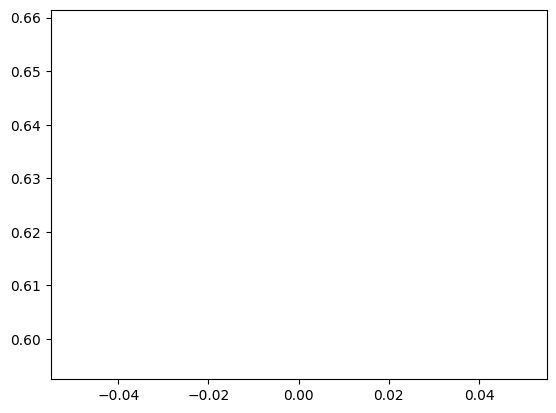

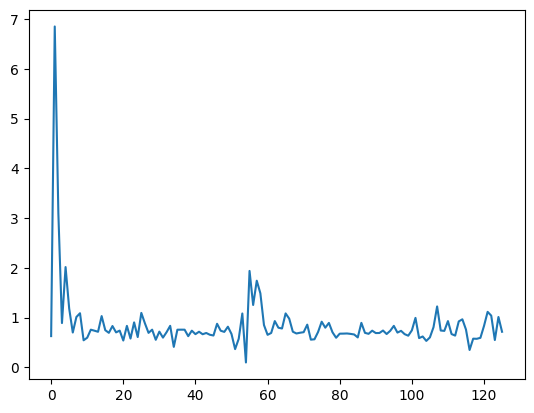

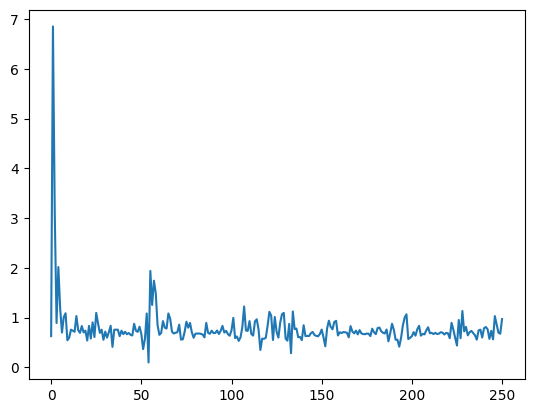

KeyboardInterrupt: ignored

In [42]:
import random
model = CL(max([len(i) for i in smiles_arr])).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99987)

n = 4
losses = []
for EPOCH in range(30):
  for i in range(0, len(smiles_arr), n):
    images_list = []
    smiles_list = []
    maxlen = 0
    ans = []
    for j in range(n):
      if random.random()>0.5: #touyunskaok
          image = deepsmiles_to_img("".join([reversed_mapping[_] for _ in smiles_arr[i+j]]))
          image = torch.tensor(image).permute(2,0,1)
          images_list.append(image)
          smiles_list.append(smiles_arr[i+j])
          maxlen = max(maxlen, len(smiles_arr[i+j]))
          ans.append(1)
      else:
          image = deepsmiles_to_img("".join([reversed_mapping[_] for _ in smiles_arr[i+j]]))
          image = torch.tensor(image).permute(2,0,1)
          images_list.append(image)
          id = -1#random.randint(0, len(smiles_arr)-1)
          smiles_list.append(smiles_arr[id])
          maxlen = max(maxlen, len(smiles_arr[id]))
          ans.append(0)
    for j in range(n):
      smiles_list[j] += [30] * (maxlen - len(smiles_list[j]))

    images_list = torch.stack(images_list).to(torch.float32)
    smiles_list = torch.tensor(smiles_list, dtype=torch.int32)

    optimizer.zero_grad()
    logits = model(images_list.to(device), smiles_list.to(device))
    loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, torch.tensor(ans, dtype=torch.float32).unsqueeze(1).to(device))
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().cpu().item())
    # print(i)
    if i%500 == 0:
      pylab.plot(losses)
      pylab.show()

In [24]:
torch.nn.functional.binary_cross_entropy_with_logits(torch.tensor([0.1,0.2,0.3,0.4]), torch.tensor([1.0,1,1,1]))

tensor(0.5775)